In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc

# Medidas de Similaridad y Representación en grafo
Además de el coeficiente de correlación, existen otras medidas de similaridad, las cuales pueden ofrecer resultados más confiables.

En este notebook, exploraremos el uso de otras dos medidas de similaridad.

De nuevo, utilizaremos los datos que preprocesamos en los notebooks anteriores:

In [2]:
workdata = pd.read_csv('./CellsData_clean.csv',index_col=0)
workdata.head()

,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,cell_9,cell_10,...,cell_28,cell_29,cell_30,cell_31,cell_33,cell_34,cell_35,cell_36,cell_37,cell_38
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## 1. Medidas de similaridad para datos binarios

En la práctica de análisis de datos no es recomendable realizar medidas de similaridad con correlación para el caso de variables binarias (variables que toman uno de dos valores posibles). Para medir similaridades se han desarrollado coeficientes más adecuados. En este notebook nos enfocaremos los coeficientes *de Russel-Rao* (**RR**) y *Jaccard* (**J**):

$J$ = $\frac{c_{11} + c_{01}}
        {c_{11} + c_{01} + c_{10}}$
        
        
$RR$ = $\frac{n - c_{11}}
       {n}$

donde *n* es el número de observaciones.

Para calcular estos coeficientes, utilizaremos las funciones definidas en la librería **scipy**:

In [3]:
from scipy.spatial.distance import jaccard
from scipy.spatial.distance import russellrao

## 2. Similaridad con el Índice de Jaccard
Para calcular la similirad de Jaccard entre dos arreglos unidimensionales que toman valores de 0 ó 1, aplicamos la función **jaccard( )** o **russellrao( )** de la siguiente forma:

In [4]:
jaccard(workdata['cell_7'],workdata['cell_8'])

1.0

In [5]:
russellrao(workdata['cell_1'],workdata['cell_23'])

0.9994897959183674

### 2.1 Matríz de distancia
Ahora haremos una función que nos regrese una matríz de distancias para una medida de similaridad alternativa al coeficiente de correlación:

In [6]:
def get_distancematrix(dataframe,distanceMeasure):
    dist_matrix = []
    numCols = len(dataframe.columns)
    for fixed_col in dataframe.columns:
        dist_col = [1-distanceMeasure(dataframe[fixed_col],dataframe.iloc[:,i]) for i in np.arange(0,numCols)]
        dist_matrix = np.append(dist_matrix,dist_col)
        
    dist_matrix = np.reshape(dist_matrix,(numCols,numCols))
    dist_matrix = np.asarray(dist_matrix)
    return(pd.DataFrame(dist_matrix,columns=dataframe.columns,index=dataframe.columns))

In [7]:
jaccard_matrix = get_distancematrix(workdata,jaccard)
rr_matrix = get_distancematrix(workdata,russellrao)

Y calculamos también, la matríz de distancia con el coeficiente de correlación:

In [8]:
cormat = np.corrcoef(np.asarray(workdata).T)
cormat = pd.DataFrame(cormat,columns=workdata.columns,index=workdata.columns)

### 2.2 Visualizando las diferentes matrices de distancia:

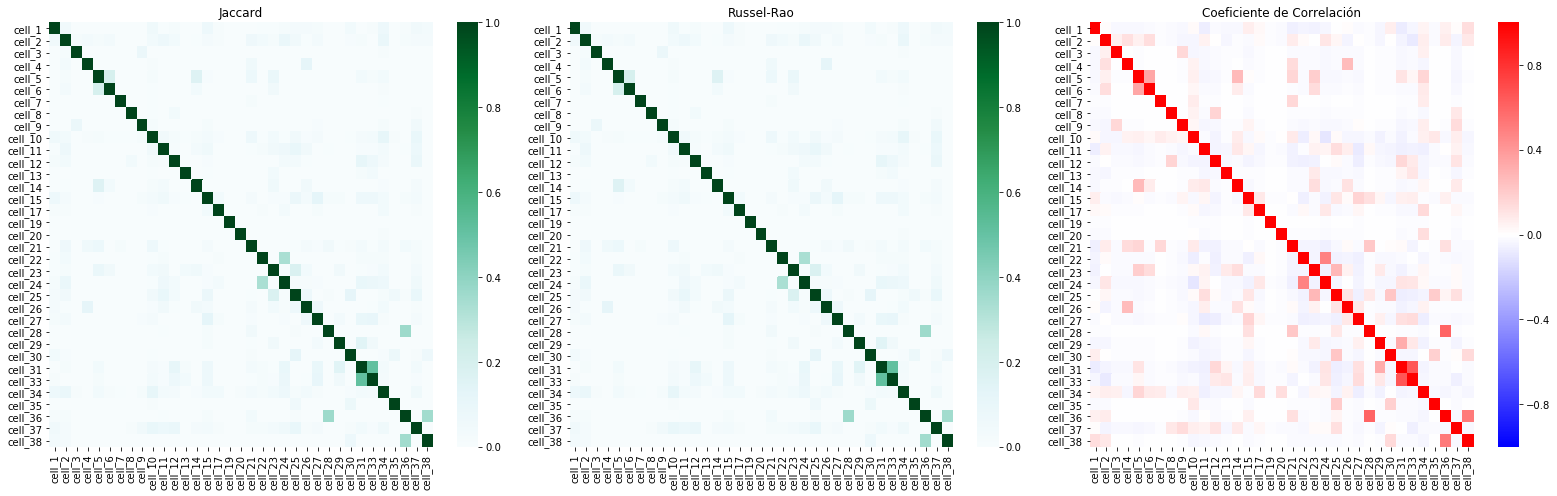

In [9]:
plt.figure(figsize=(22,7))

plt.subplot(131)
ax = plt.gca()
sns.heatmap(jaccard_matrix,
            xticklabels=workdata.columns, #Etiquetas de la gráfica
            yticklabels=workdata.columns,
            cmap='BuGn', #escala de color
             )
plt.title('Jaccard')

plt.subplot(132)
ax = plt.gca()
sns.heatmap(jaccard_matrix,
            xticklabels=workdata.columns, #Etiquetas de la gráfica
            yticklabels=workdata.columns,
            cmap='BuGn' #escala de color
             )
plt.title('Russel-Rao')

plt.subplot(133)
ax = plt.gca()
sns.heatmap(cormat,
            cmap='bwr',
            xticklabels=workdata.columns, #Etiquetas de la gráfica
            yticklabels=workdata.columns,
            vmin=-1 #escala de color
             )
plt.title('Coeficiente de Correlación')

plt.tight_layout()

## 3. Representación de la conectividad utilizando teoría de gráficas

Una representación muy util de este tipos de registros es a través de redes o grafos, para esto, utilizaremos la paquetería **networkx** de python y representaremos las matrices de distancia obtenidas con la función definida en el paso anterior como gráficas.

In [10]:
import networkx as nx

### 3.1 Filtrando valores
Primero, haremos cero los coeficientes más pequeños de la matríz de distancia para obtener una figura más limpia. Para esto, primero observaremos la distribución de los valores de similaridad entre todos los pares de células:

Text(0, 0.5, 'Frecuencia')

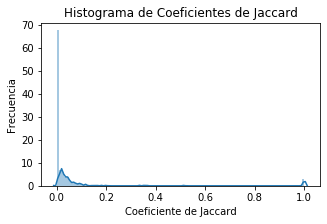

In [11]:
fig = plt.figure(figsize=(5,3))
numCols = len(workdata.columns) #Número de células
sim_scores = np.reshape(jaccard_matrix.values, numCols*numCols) #Cambiamos el arreglo a 1D

#Graficamos el histograma:
sns.distplot(sim_scores,kde=True,bins=100)
plt.title('Histograma de Coeficientes de Jaccard')
plt.xlabel('Coeficiente de Jaccard')
plt.ylabel('Frecuencia')

Ahora eligiremos un umbral para filtrar valores:

In [12]:
threshold = .1

Y, finalmente, una función para asignar un 0 a los valores por debajo que aquél umbral:

In [13]:
jaccard_matrix_replaced = jaccard_matrix.apply(lambda x: [y if y >= threshold else 0 for y in x])

### 3.2 Definir el grafo
Ahora, definiremos algunas propiedades del grafo:

In [14]:
#Tomaremos la matríz de Jaccard (hay que convertirla a 'array' usando .values) 
graph = nx.from_numpy_matrix(jaccard_matrix_replaced.values) 

# Indicamos que queremos una gráfica dirigida
#graph = graph.to_directed() 

nodes = graph.nodes()       # Nodos del grafo

#Aristas y pesos de conexión:
edges,weights = zip(*nx.get_edge_attributes(graph,'weight').items()) 
colors = np.asarray(weights)

#Posición de los nodos en la figura:
positions = nx.spring_layout(graph)

#Definimos las etiquetas de los nodos
labels1={} 
for i in range (0,len(workdata.columns)):
    labels1[i]=workdata.columns[i]

### 3.3 Dibujar el grafo

Finalmente, dibujaremos el grafo anteriormente definido:

/Users/nelion/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


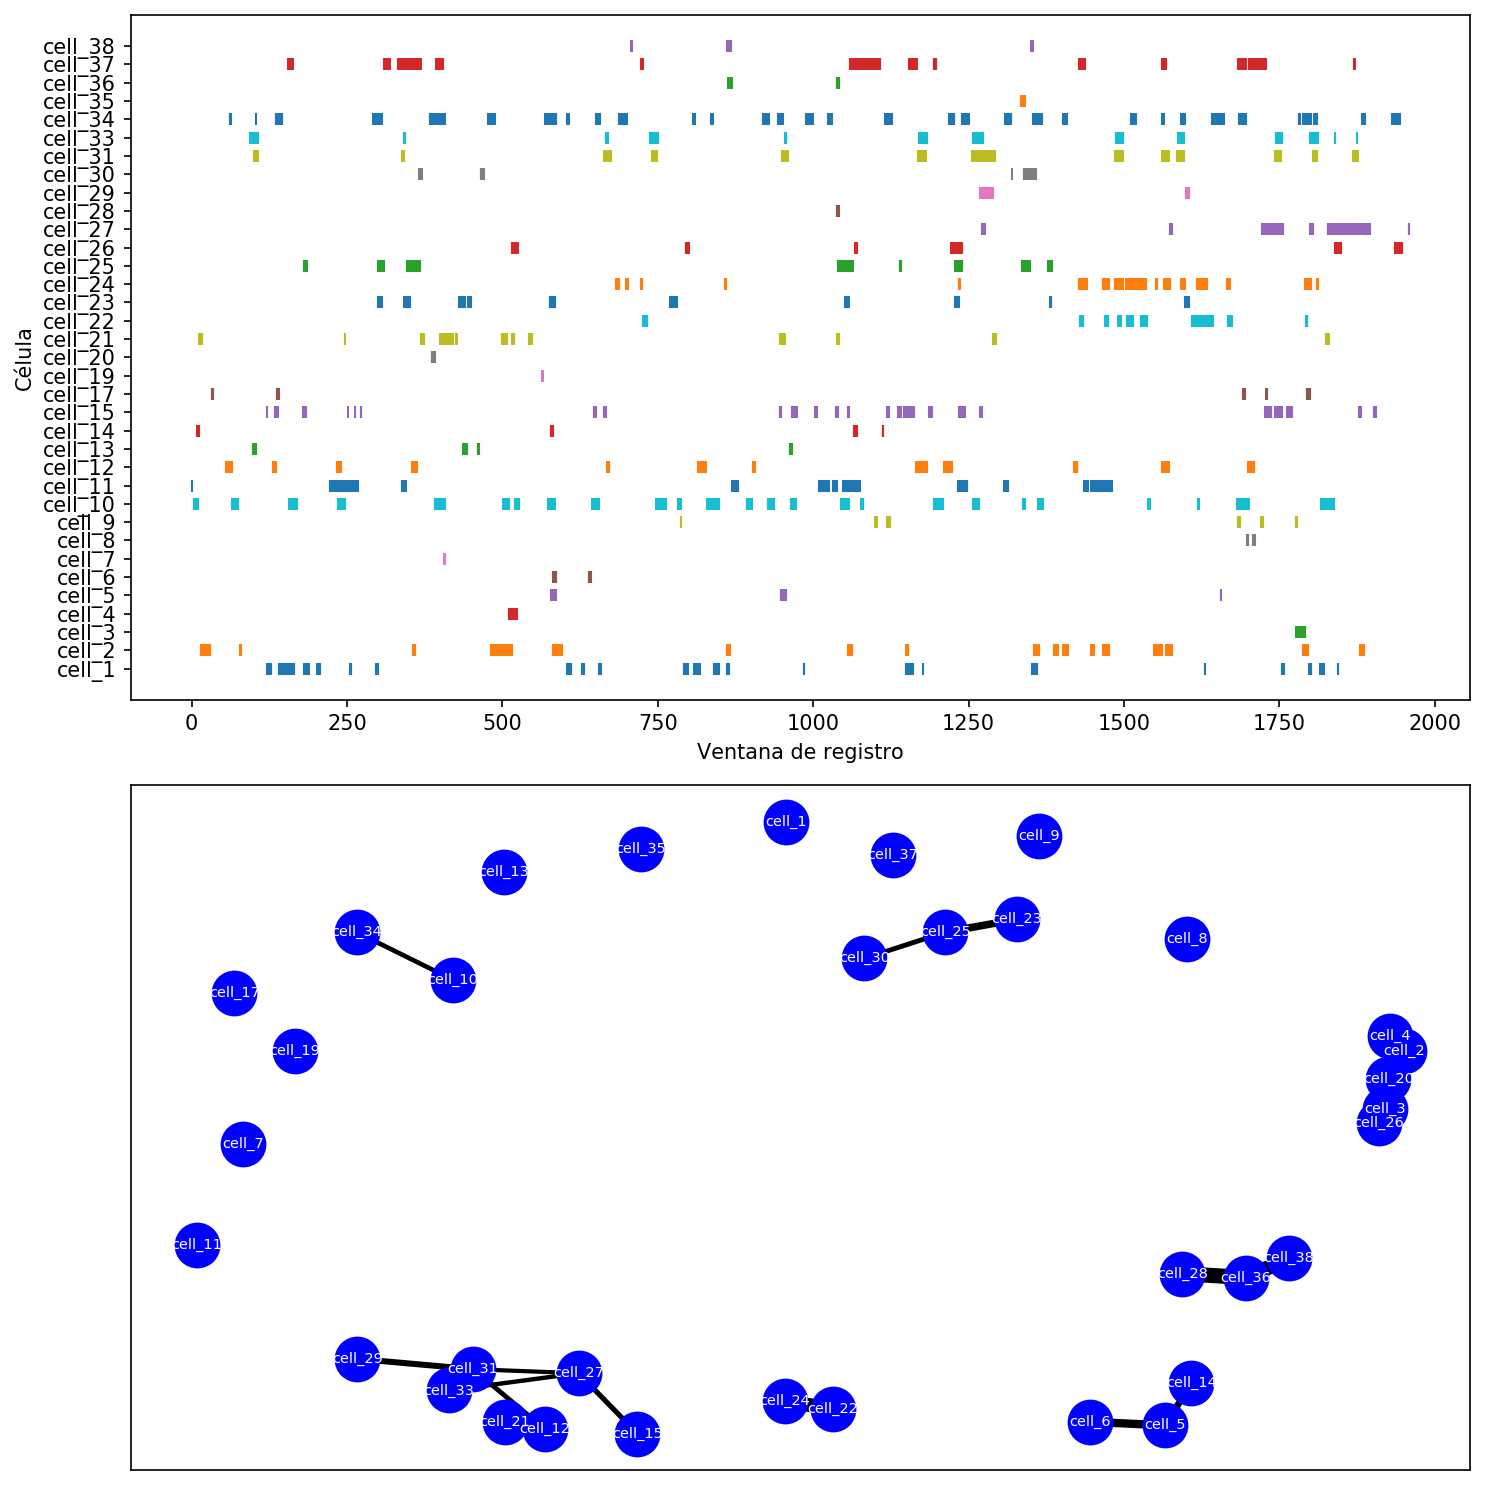

In [16]:
fig = plt.figure(figsize=(10,10),dpi=150)

############
# Red
############

plt.subplot(211)
plt.style.use('default')
#Para cada célula, traza una línea vertical cuando esta presenta un spike
for cell in range(len(workdata.columns)):
    spikeInds = sc.where(workdata.iloc[:,cell]==1)[0] #Índices del spike
    plt.plot(spikeInds, (cell)*sc.ones(len(spikeInds)),'|')

ax=plt.gca()
plt.yticks(np.arange(0, len(workdata.columns))) 
ax.set_yticklabels(workdata.columns) #Asigna la etiqueta de cada célula a la gráfica

plt.ylabel('Célula')
plt.xlabel('Ventana de registro')

plt.draw()
plt.tight_layout()


############
# Raster
############

plt.subplot(212)

#Dibujamos las etiquetas
nx.draw_networkx_labels(graph,
                        positions,
                        labels1,
                        font_size=7,
                        font_color ="white") #Color de las etiquetas
#Dibujamos las aristas
nx.draw_networkx_edges(graph, positions, alpha=1,width=colors*20)
#Dibujamos los nodos
nx.draw_networkx_nodes(graph, 
                       positions, 
                       alpha=1,
                       nodelist=nodes, 
                       node_color='blue', 
                       with_labels=False, 
                       node_size=440)

plt.grid(False)